In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,confusion_matrix
import joblib

warnings.filterwarnings('ignore')

df = pd.read_csv('https://raw.githubusercontent.com/LeeMorinUCF/QMB6358S22/main/demo_24_Classification/credit.csv')
print(df.isna().sum())
print(df.duplicated().sum())
print(df.dtypes)
print(df.nunique())
df.rename(columns={"property":"prop"},inplace=True)

Default            0
checkingstatus1    0
duration           0
history            0
purpose            0
amount             0
savings            0
employ             0
installment        0
status             0
others             0
residence          0
property           0
age                0
otherplans         0
housing            0
cards              0
job                0
liable             0
tele               0
foreign            0
dtype: int64
0
Default             int64
checkingstatus1    object
duration            int64
history            object
purpose            object
amount              int64
savings            object
employ             object
installment         int64
status             object
others             object
residence           int64
property           object
age                 int64
otherplans         object
housing            object
cards               int64
job                object
liable              int64
tele               object
foreign            objec

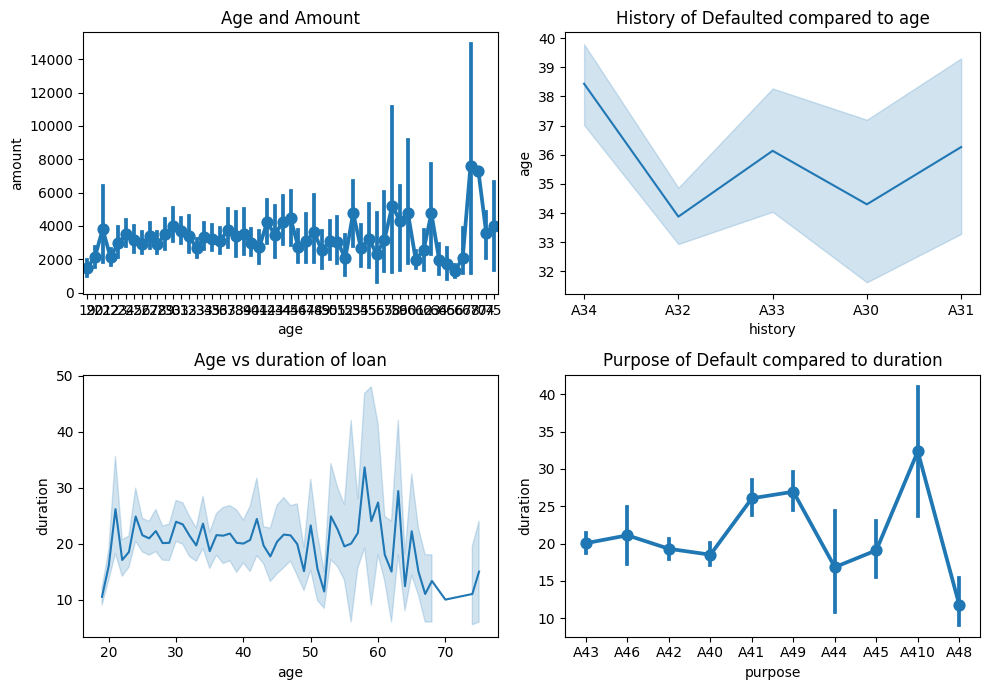

In [4]:
fig, axs = plt.subplots(2,2,figsize=(10,7))
sns.pointplot(x='age',y='amount',ax=axs[0,0],data=df)
axs[0,0].set_title('Age and Amount')

sns.lineplot(x='history',y='age',ax=axs[0,1],data=df)
axs[0,1].set_title('History of Defaulted compared to age')
sns.lineplot(x='age',y='duration',ax=axs[1,0],data=df,palette='Blues')
axs[1,0].set_title('Age vs duration of loan')
sns.pointplot(x='purpose',y='duration',ax=axs[1,1],data=df)
axs[1,1].set_title('Purpose of Default compared to duration')
plt.tight_layout()
plt.show()


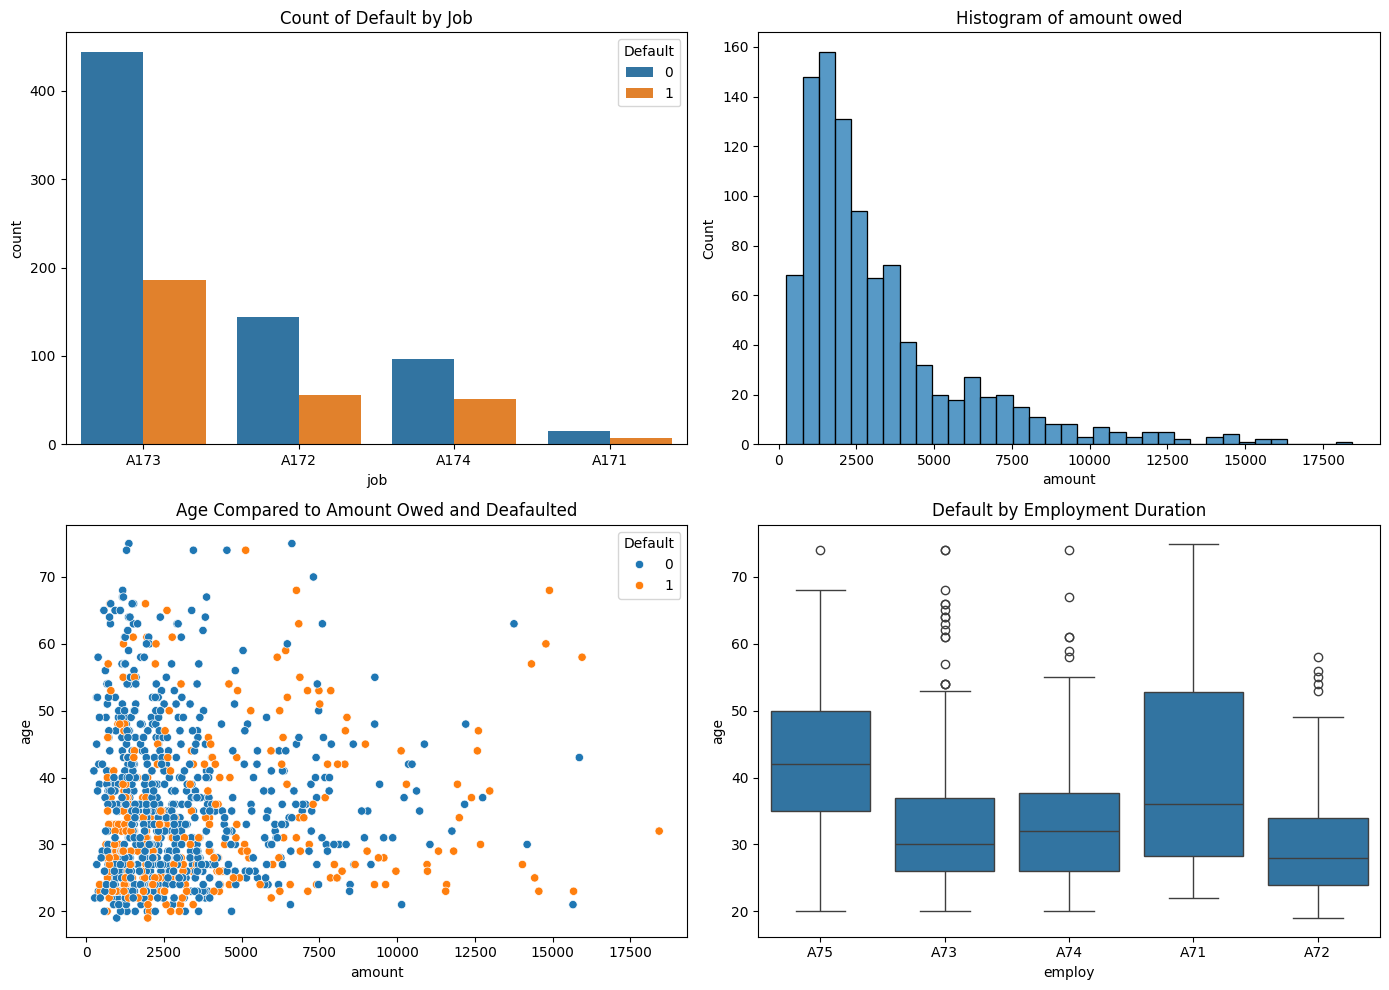

In [5]:
fig, axs = plt.subplots(2,2,figsize=(14, 10))
sns.countplot(x='job',hue='Default',ax=axs[0,0],data=df)
axs[0,0].set_title('Count of Default by Job')
sns.histplot(x='amount',ax=axs[0,1],data=df,palette='viridis')
axs[0, 1].set_title('Histogram of amount owed')
sns.scatterplot(x='amount',y='age',ax=axs[1,0],data=df,hue='Default')
axs[1, 0].set_title('Age Compared to Amount Owed and Deafaulted')
sns.boxplot(x='employ',y='age', ax=axs[1,1], data=df)
axs[1,1].set_title('Default by Employment Duration')
plt.tight_layout()
plt.show()



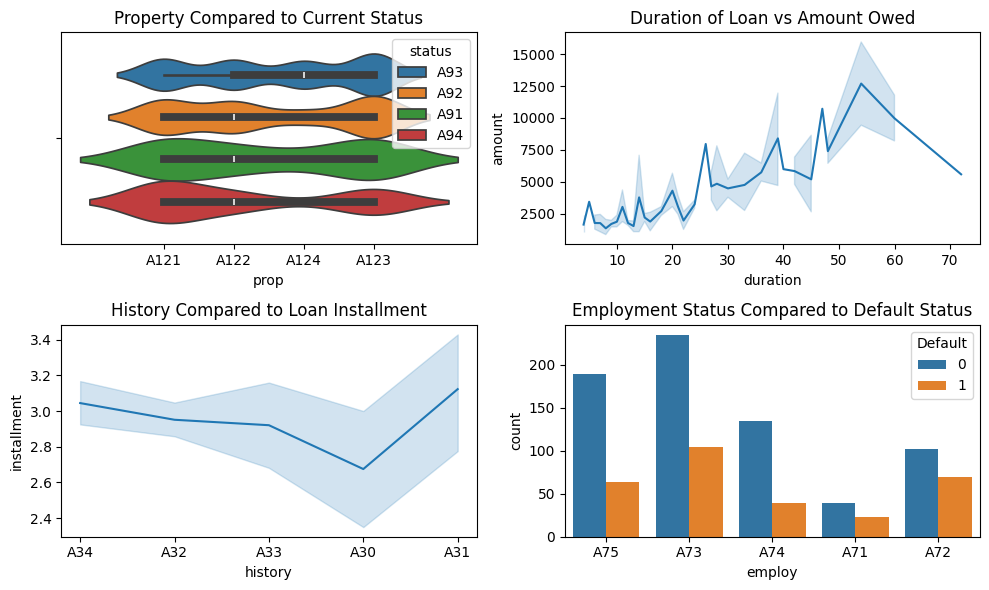

In [6]:
fig,axs = plt.subplots(2,2,figsize=(10,6))
sns.violinplot(data=df,ax=axs[0,0],x='prop',hue='status')
axs[0,0].set_title("Property Compared to Current Status")
sns.lineplot(data=df,ax=axs[0,1],x='duration',y='amount')
axs[0,1].set_title("Duration of Loan vs Amount Owed")
sns.lineplot(data=df,ax=axs[1,0],x='history',y='installment')
axs[1,0].set_title("History Compared to Loan Installment")
sns.countplot(data=df,ax=axs[1,1],x='employ',hue='Default')
axs[1,1].set_title("Employment Status Compared to Default Status")
plt.tight_layout()
plt.show()

In [8]:

X = df.drop("Default",axis=1)
y = df['Default']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)


encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()



ct = make_column_transformer(
    (encoder,X.select_dtypes(include='object').columns),
    (scaler,X.select_dtypes(include='number').columns),remainder='passthrough')




def evaluate(y_test,pred,pred_prob,model_name,cv_scores):

    result = {
        "Model":model_name,
        "Accuracy":acc,
        "Rocscore":roc,
        "Cross-Validation Score":cv_scores.mean()
        }
    return result



dict_list = []

models = {
    "LogisticRegression":LogisticRegression(),
    "RandomForestClassifier":RandomForestClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier(),
    "BaggingClassifier":BaggingClassifier(),
    "svc":SVC(probability=True),
    "knn":KNeighborsClassifier()

}


for model_name,model in models.items():
    pipe = make_pipeline(ct,model).fit(X_train,y_train)
    pred = pipe.predict(X_test)
    pred_prob = pipe.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, pred)
    roc = roc_auc_score(y_test, pred_prob)
    cv_scores = cross_val_score(pipe, X_train,y_train,cv=5,scoring="roc_auc")
    evaluation_result = evaluate(y_test, pred, pred_prob,model_name, cv_scores)
    dict_list.append(evaluation_result)


df_results = pd.DataFrame(dict_list)
print(df_results.head())

                        Model  Accuracy  Rocscore  Cross-Validation Score
0          LogisticRegression     0.795  0.818488                0.770425
1      RandomForestClassifier     0.805  0.811876                0.771163
2  GradientBoostingClassifier     0.790  0.815843                0.755407
3           BaggingClassifier     0.785  0.765957                0.746705
4                         svc     0.790  0.809713                0.771696


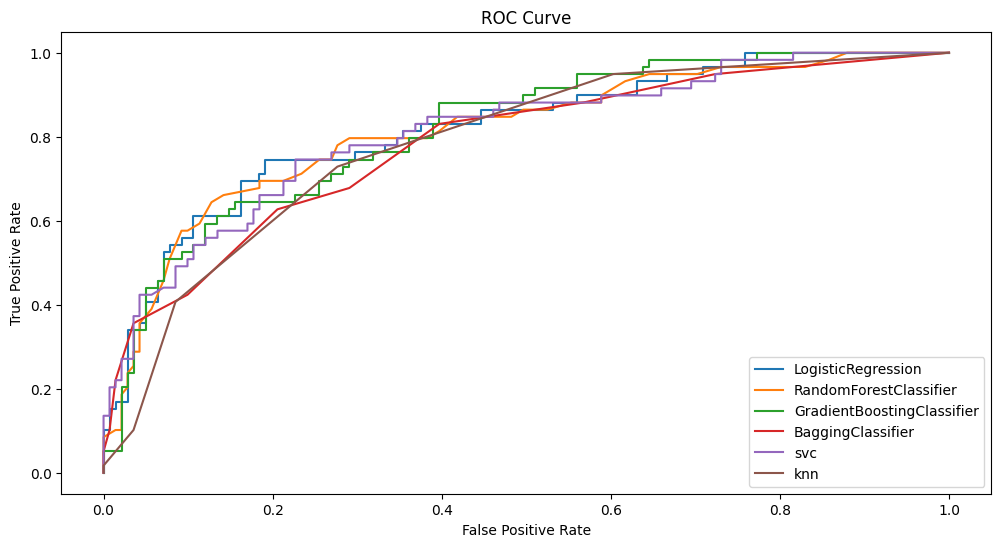

In [9]:


def plot_roc_curve(models,X_test,y_test):
    plt.figure(figsize=(12,6))
    
    for name, model in models.items():
        pipe = make_pipeline(ct,model).fit(X_train,y_train)
        pred_prob = pipe.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test,pred_prob)
        plt.plot(fpr,tpr,label=name)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


plot_roc_curve(models, X_test, y_test)

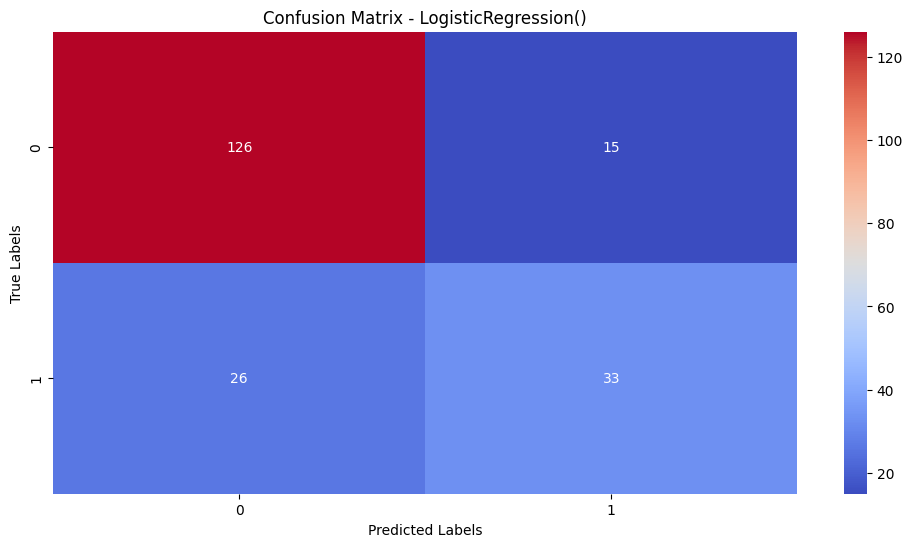

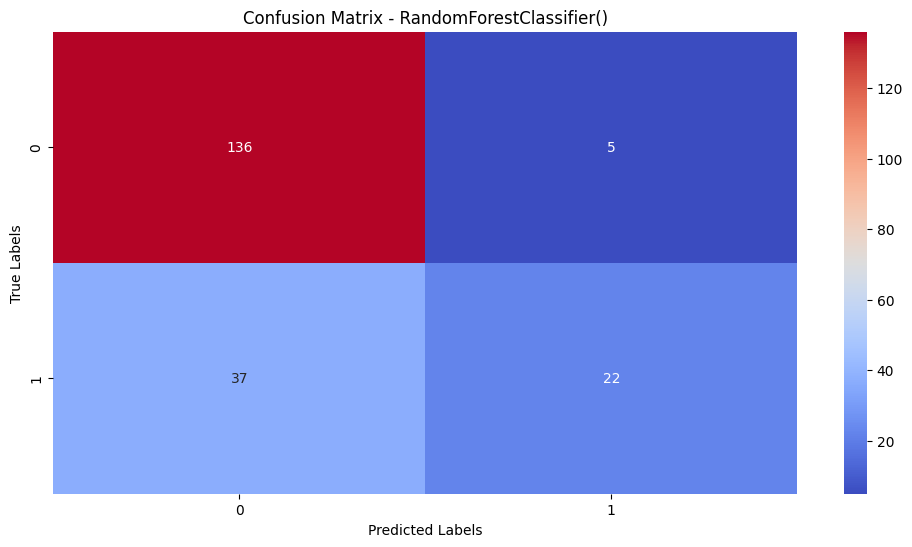

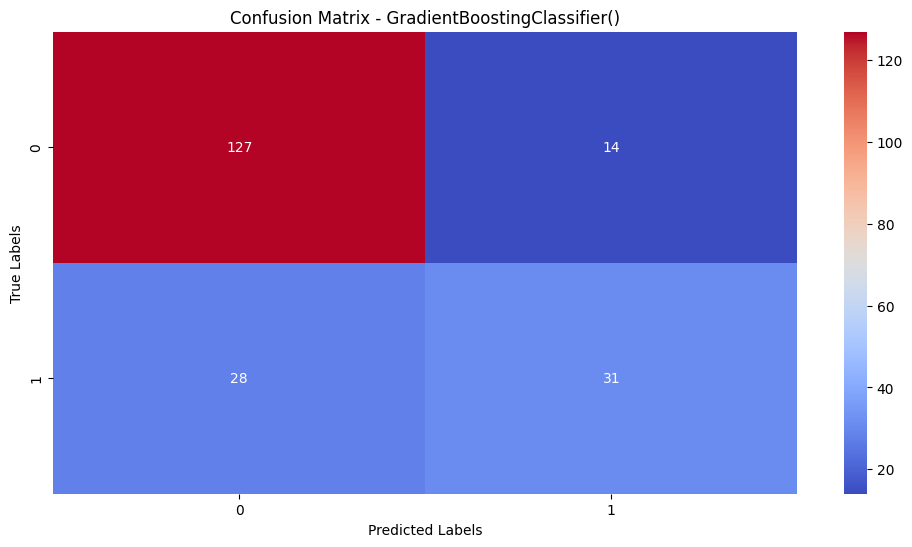

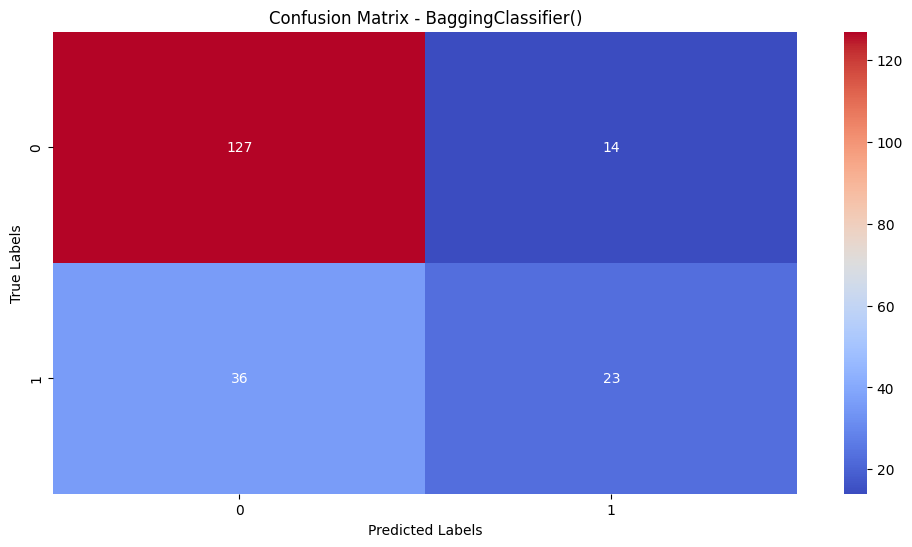

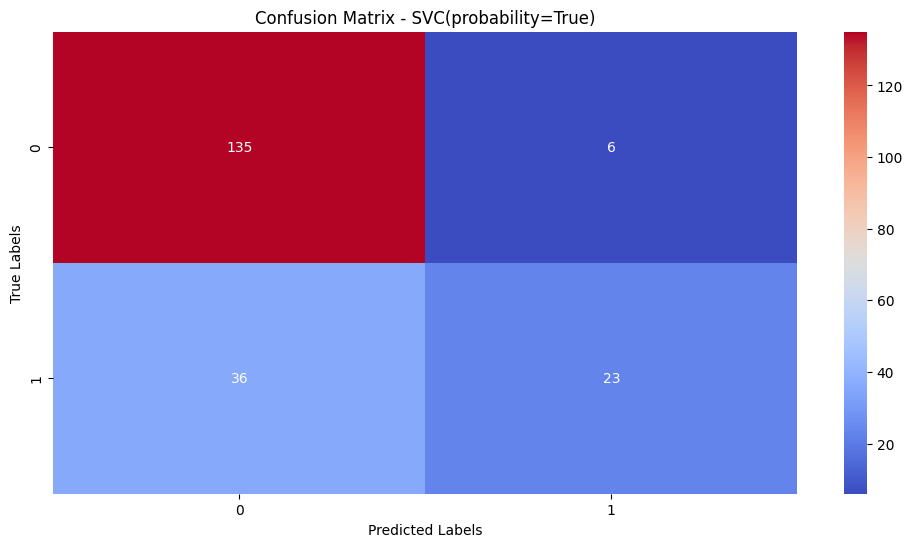

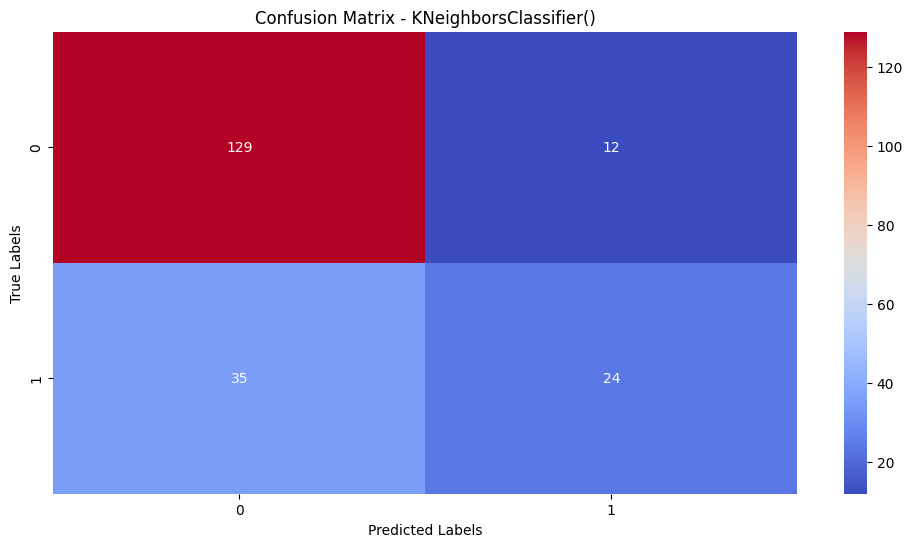

In [10]:
def plot_confusion_matrix(y_test,y_pred,models):
    conmap = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(12,6))
    sns.heatmap(conmap,annot=True,fmt='d',cmap='coolwarm')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {models}')
    plt.show()




for model_name, model in models.items():

    pipe = make_pipeline(ct,model).fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    

    plot_confusion_matrix(y_test, y_pred, model)

In [11]:



logistic_regression_params = {
    'logisticregression__C': [0.001,0.01,0.1,1,10],
    'logisticregression__solver':['lbfgs','newton-cg','liblinear','sag','saga'],
    'logisticregression__max_iter':[1000,5000,1000],
    'logisticregression__penalty':['l1', 'l2', 'elasticnet', 'none']
}

gradient_boosting_params = {
    'gradientboostingclassifier__learning_rate': [0.1, 0.01],
    'gradientboostingclassifier__n_estimators': [100,200,300],
    'gradientboostingclassifier__max_depth': [3,4,5]
}

random_forest_params = {
    'randomforestclassifier__n_estimators': [50,100,200],
    'randomforestclassifier__max_depth': [None,10,20],
    'randomforestclassifier__min_samples_leaf':[1,2,4],
    'randomforestclassifier__max_features': ['sqrt','log2',None],
    "randomforestclassifier__criterion":["gini", "entropy"]
}
SVC(probability=True).get_params(deep=True)
svc_params = {
    'svc__C': [0.1,1,10,100,1000],
    'svc__gamma': [1,0.1,0.01,0.001,0.0001],
    'svc__kernel': ['rbf']
}

bagging_classifier_params = {
    'baggingclassifier__n_estimators': [50,100,200],
    'baggingclassifier__max_samples' : [1.0,0.8,0.6],
    'baggingclassifier__max_features': [1.0,0.8,0.6]
}


knn_params = {
    'kneighborsclassifier__n_neighbors' : [5,7,9,11,13,15],
               'kneighborsclassifier__weights' : ['uniform','distance'],
               'kneighborsclassifier__metric' : ['minkowski','euclidean','manhattan']
               }


models = {
    "LogisticRegression": (LogisticRegression(), logistic_regression_params),
    "RandomForestClassifier": (RandomForestClassifier(), random_forest_params),
    "GradientBoostingClassifier": (GradientBoostingClassifier(), gradient_boosting_params),
    "SVC": (SVC(probability=True), svc_params),
    "BaggingClassifier": (BaggingClassifier(), bagging_classifier_params),
    "kneighborsclassifier":(KNeighborsClassifier(),knn_params)
}

best_score = []


for model_name,(model,params) in models.items():
    pipe = make_pipeline(ct,model)
    grid_search = GridSearchCV(pipe,params,cv=5,scoring="roc_auc")
    grid_search.fit(X_train,y_train)
    print(f'Best Params for {model_name} : {grid_search.best_params_}')
    print(f'Best Score for {model_name} : {grid_search.best_score_ * 100:.2f}%')
    scores = {"Model":model_name,"RocAuc Score":grid_search.best_score_}
    best_score.append(scores)


best_score_df = pd.DataFrame(best_score)
print(best_score_df.head())

Best Params for LogisticRegression : {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best Score for LogisticRegression : 77.87%
Best Params for RandomForestClassifier : {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 200}
Best Score for RandomForestClassifier : 79.25%
Best Params for GradientBoostingClassifier : {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 300}
Best Score for GradientBoostingClassifier : 76.58%
Best Params for SVC : {'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Score for SVC : 77.35%
Best Params for BaggingClassifier : {'baggingclassifier__max_features': 0.6, 'baggingclassifier__max_samples

In [ ]:
"""Best Parameters from Hypderparameter tuning bagging classifier"""

bagging_clf = make_pipeline(ct,BaggingClassifier(max_features=0.6,max_samples=0.6,n_estimators=200)).fit(X_train,y_train)
y_pred = bagging_clf.predict(X_test)
y_pred_prob = bagging_clf.predict_proba(X_test)[:,1]
print('Accuracy of Optimized Bagging Classifier with Optimized HyperParamaeters\n')
print(accuracy_score(y_test, y_pred))
print('RocAuc Score of Bagging Classifier with Optimized Parameters\n')
print(roc_auc_score(y_test,y_pred_prob))

In [14]:
def predict(model,features):

    predictions = model.predict(features)
    pred_probabilities = model.predict_proba(features)[:,1]
    
    

    data = []
    for pred,pred_prob in zip(predictions,pred_probabilities):
        data.append([pred,pred_prob])
    
    return data,pred_probabilities




if __name__ == "__main__":
    
    model = joblib.load("models/bagging.joblib")
    features = joblib.load("models/features.joblib")
    predictions, pred_probabilities = predict(model,features)

    print('Predictions:')
    for i, (pred, prob) in enumerate(predictions):
        if (i+1) % 10== 0:
            print(f"Sample {i+1}: Prediction = {pred}, Probability of Default = {prob:.2f}")

Predictions:
Sample 10: Prediction = 1, Probability of Default = 0.83
Sample 20: Prediction = 0, Probability of Default = 0.08
Sample 30: Prediction = 1, Probability of Default = 0.82
Sample 40: Prediction = 0, Probability of Default = 0.33
Sample 50: Prediction = 0, Probability of Default = 0.10
Sample 60: Prediction = 1, Probability of Default = 0.57
Sample 70: Prediction = 0, Probability of Default = 0.12
Sample 80: Prediction = 0, Probability of Default = 0.28
Sample 90: Prediction = 1, Probability of Default = 0.74
Sample 100: Prediction = 0, Probability of Default = 0.17
Sample 110: Prediction = 0, Probability of Default = 0.17
Sample 120: Prediction = 0, Probability of Default = 0.16
Sample 130: Prediction = 1, Probability of Default = 0.57
Sample 140: Prediction = 0, Probability of Default = 0.14
Sample 150: Prediction = 0, Probability of Default = 0.01
Sample 160: Prediction = 0, Probability of Default = 0.02
Sample 170: Prediction = 1, Probability of Default = 0.53
Sample 180